### HTML Parsing

In this notebook I will parse the data from 40,000+ AUR packages with beautifulsoup and put the data into a pandas DataFrame. 

In [1]:
from selenium import webdriver
import re
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import requests
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt
import networkx

In [ ]:
def get_package_from_link(link):
    if link[-1] == "/":
        link = link[:-1]
    link = link.split("=")[-1]
    link = link.split("/")[-1]
    return link

pkg_dict_list = []
comments_dict_list = []

err_count = 0
err_files = []
os.chdir('../html/pkgs/')
for _, file in enumerate(os.listdir()):
    print(_, end=" ")
    if file != 'ghostdriver.log':
        f = open(file, 'r')
        html = f.read()
        b = BeautifulSoup(html, 'lxml')
        try:
            print(_)
            
            # attributes
            pkginfo = b.find('table', attrs={'id':'pkginfo'}).find_all('tr')
            
            attr_dict = {}
            for attribute in pkginfo:
                label = attribute.find('th').text.strip(": ")
                value = attribute.find('td').text
                value = value.replace('\\n', '\n')
                value = value.replace('\\t', '\t')
                value = re.sub('[\t+]', '', value)
                value = re.sub('[\n+]', '', value)
                attr_dict[label] = value

            dependencies = []
            pkgdeps = b.find('ul', attrs={'id':'pkgdepslist'})
            if pkgdeps:
                for p in pkgdeps.find_all('li'):
                    for link in p.find_all('a'):
                        dependencies.append(link['href'])
                dependencies = list(set([get_package_from_link(d) for d in dependencies]))
            attr_dict['pkgdeps'] = dependencies

            requirements = []
            pkgreqs = b.find('ul', attrs={'id':'pkgreqslist'})
            if pkgreqs:
                for p in pkgreqs.find_all('li'):
                    for link in p.find_all('a'):
                        requirements.append(link['href'])
                requirements = list(set([get_package_from_link(d) for d in requirements]))
            attr_dict['pkgreqs'] = requirements
            
            pkg_dict_list.append(attr_dict)

#             # pinned comments
#             pinned_comments = []
#             pinned_comment_section = b.find_all('div', attrs={'id':'news'})
#             if pinned_comment_section:
#                 pinned_comments = pinned_comment_section.find_all('')
                
#             # regular comments
            
#             regular_comments = []
            
#             comment_section = b.find_all('div', attrs={'id':'news'})[-1]
            
#             comment_section.find_all
            
            
            
        except: 
            err_count += 1
            err_files.append(file)
            print("ERROR")
            print(err_count)
            print(file)
        b.decompose()
        f.close()
        

In [9]:
df = pd.DataFrame(pkg_dict_list)
df.to_csv('../csv/aur_package_data.csv')

In [ ]:
df = pd.read_csv('../csv/aur_package_data.csv')

In [7]:
df.sample()

,Conflicts,Description,First Submitted,Git Clone URL,Groups,Keywords,Last Packager,Last Updated,Licenses,Maintainer,Package Base,Popularity,Provides,Replaces,Submitter,Upstream URL,Votes,pkgdeps,pkgreqs
32359,NaN,Simple Signal/Slot implementation,2015-05-18 11:23:00,https://aur.archlinux.org/python-signalslot.gi...,NaN,development,MazeChaZer,2015-06-27 11:16,MIT,MazeChaZer,python-signalslot,0.000000,NaN,NaN,MazeChaZer,https://github.com/numergy/signalslot,0,[python],[]


### Cumulative count of AUR Packages 

Let's take a look at the cumulative count of AUR packages to see how the community has grown since it came into existence. 

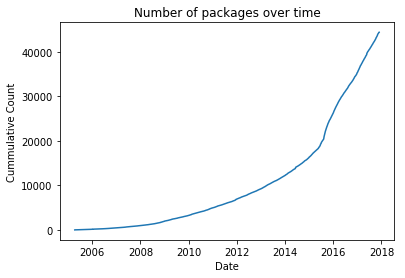

In [5]:
df = df[df['First Submitted'].notnull()]
df["First Submitted"] = pd.to_datetime(df['First Submitted'])
list_of_dates = df["First Submitted"].sort_values()
counts = np.arange(0, len(list_of_dates))
_ = plt.plot(list_of_dates, counts)
_ = plt.title('Number of packages over time')
_ = plt.xlabel('Date')
_ = plt.ylabel('Cummulative Count')
# _ = plt.plot(counts, np.gradient(list_of_dates))

In [13]:
df[df.Groups.notnull()].sample()

,Conflicts,Description,First Submitted,Git Clone URL,Groups,Keywords,Last Packager,Last Updated,Licenses,Maintainer,Package Base,Popularity,Provides,Replaces,Submitter,Upstream URL,Votes,pkgdeps,pkgreqs
10287,NaN,GSettings schemas for MATE Desktop (GTK2 version),2017-03-19 18:29,https://aur.archlinux.org/mate-desktop-schemas...,mate-gtk2,NaN,newbthenewbd,2017-07-28 18:22,"GPL,LGPL",newbthenewbd,mate-desktop-schemas-gtk2,0.015823,NaN,NaN,newbthenewbd,http://mate-desktop.org,2,"[gobject-introspection, intltool]","[marco-gtk2, mate-desktop-gtk2, mate-utils-gtk..."
